Project1 - Speech recognition

In [1]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import wavfile
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import winsound
import time

from keras import backend as K
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D,Conv1D,MaxPooling2D,AveragePooling1D,MaxPooling1D
from keras.layers import Dense,Flatten,Dropout
from keras import initializers,optimizers,backend as k
from sklearn.metrics import confusion_matrix
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [ ]:
#Control on the frequencies of the wav files of the dataset
frequencies = {}
signal_lengths = {}
folders = os.listdir('./audio_files')
for folder in tqdm(folders):
    entries = os.listdir('./audio_files'+'/'+folder)
    for entry in entries:    
        fs, signal = wavfile.read('./audio_files'+'/'+folder+'/'+entry)
        if len(signal) in signal_lengths:
            signal_lengths[len(signal)]+=1
        else:
            signal_lengths[len(signal)]=1
        if fs in frequencies.keys():
            frequencies[fs]+=1
        else:
            frequencies[fs]=1

In [ ]:
x = []
y = []
for i in signal_lengths:
    x.append(i)
    y.append(signal_lengths[i])
tot = 0
for i in range(81):
    tot = tot + y[i]
freq = []
counts = []
for j in frequencies:
    freq.append(str(j)+'Hz')
    counts.append(frequencies[j])
        
labels = []
values = []
one_second = 0
less = 0
more = 0

for i in range(len(x)):
    if x[i]==16000:
        one_second+=y[i]
    elif x[i]<16000:
        less+=y[i]
    else:
        more+=y[i]
labels.append('=1 second')
values.append(one_second/tot*100)
labels.append('<1 second')
values.append(less/tot*100)
labels.append('>1 second')
values.append(more/tot*100)
fig = make_subplots(rows=1, cols=2,specs=[[{"type": "domain"},{"type": "domain"}]],
                    subplot_titles=['Duration .wav files', 'Frequency .wav files'])
fig.add_trace(go.Pie(labels=labels, values=values),row=1,col=1)
fig.add_trace(go.Pie(labels=freq, values=counts),row=1,col=2)
fig.update_layout(height=400, width=700)
fig.show()

In [30]:
def creation_filterbank(fs,signal):
        frame_size = 0.025 #duration of a frame [s]
        frame_stride = 0.01 #duration of the overlap between 2 consecutive frames [s]
        frame_length, frame_step = frame_size*fs, frame_stride*fs
        signal_length = len(signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(np.ceil(float(np.abs(signal_length-frame_length))/frame_step))
        NFFT=400
        
        pad_signal_length = num_frames*frame_step+frame_length
        z = np.zeros((pad_signal_length-signal_length))
        pad_signal = np.append(signal,z)
        
        indices = np.tile(np.arange(0,frame_length),(num_frames,1))+np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32,copy=False)]
        frames *= np.hamming(frame_length)
        
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
        
        nfilt=40
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)# Equally spaced in Mel scale
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((NFFT + 1) * hz_points / fs)
        
       
        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        filter_banks = 20 * np.log10(filter_banks)
        filter_banks -= (np.mean(filter_banks,axis=0)+1e-8)
        return filter_banks,len(signal)

In [ ]:
folders = os.listdir('./audio_files')
classes = 0 #iterator for the classes
words_name = [] #list containing names of the classes
class_samples = [] #vector containing number of samples for each class
#of the training set

dataset1 = [] #training set
dataset2 = [] #validation set
dataset3 = [] #test set
output1 = [] #labels of the training set
output2 = [] #labels of the validation set
output3 = [] #labels of the test set
with open('validation_list.txt') as f:
    validation_list = f.readlines()
with open('testing_list.txt') as g:
    testing_list = g.readlines()

for folder in tqdm(folders):
    entries = os.listdir('./audio_files'+'/'+folder)
    for entry in entries:
        inserted = False
        fs, signal = wavfile.read('./audio_files'+'/'+folder+'/'+entry)
        filter_banks,length=creation_filterbank(fs,signal)
        for i in validation_list:
            if ''+folder+'/'+entry==i[0:len(folder+'/'+entry)]:
                dataset2.append(filter_banks)
                output2.append(classes)
                inserted=True
                if len(words_name)>0:
                    if words_name[-1]!=folder:
                        words_name.append(folder)
                else:
                    words_name.append(folder)
        if inserted==False:            
            for i in testing_list:
                if folder+'/'+entry==i[0:len(folder+'/'+entry)]:
                    dataset3.append(filter_banks)
                    output3.append(classes)
                    inserted = True
                    if len(words_name)>0:
                        if words_name[-1]!=folder:
                            words_name.append(folder)
                    else:
                        words_name.append(folder)
        if inserted==False:
            dataset1.append(filter_banks)
            output1.append(classes)
            if len(words_name)>0:
                if words_name[-1]!=folder:
                    words_name.append(folder)
                    class_samples.append(1)
                else:
                    class_samples[classes]+=1
            else:
                words_name.append(folder)
                class_samples.append(1)
    classes=classes+1

In [ ]:
tot = np.sum(class_samples)
class_samples/=tot
labels = ['training set','validation set','test set']
colors = [[1,0,0],[0,1,0],[0,0,1]]
x=[len(dataset1),len(dataset2),len(dataset3)]

plt.figure()
plt.pie(x,labels=labels, autopct='%1.1f%%',colors=colors)
plt.title('Data partition')
plt.show()

plt.figure(figsize=(10,4))
plt.bar(words_name,class_samples)
plt.title('Samples per class')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

In [ ]:
j = 0
plt.figure()
plt.matshow(dataset1[j].T,cmap=plt.cm.jet)
plt.xlabel('Time')
plt.ylabel('Filter banks')
plt.show()

In [ ]:
training_samples=0
validation_samples=0
test_samples=0
for i in tqdm(range(len(dataset1))):
    if dataset1[i].shape[0]==98 and dataset1[i].shape[1]==40:
        training_samples+=1
for i in tqdm(range(len(dataset2))):
    if dataset2[i].shape[0]==98 and dataset2[i].shape[1]==40:
        validation_samples+=1
for i in tqdm(range(len(dataset3))):
    if dataset3[i].shape[0]==98 and dataset3[i].shape[1]==40:
        test_samples+=1
training_set = np.zeros((training_samples,40,98))
training_labels = np.zeros((training_samples,classes))
validation_set = np.zeros((validation_samples,40,98))
validation_labels = np.zeros((validation_samples,classes))
test_set=np.zeros((test_samples,40,98))
test_labels=np.zeros((test_samples,classes))
j=0
for i in tqdm(range(len(dataset1))):
        if dataset1[i].shape[0]==98 and dataset1[i].shape[1]==40:
            training_set[j]=dataset1[i].T
            training_labels[j,output1[i]]=1
            j+=1
j=0
for i in tqdm(range(len(dataset2))):
        if dataset2[i].shape[0]==98 and dataset2[i].shape[1]==40:
            validation_set[j]=dataset2[i].T
            validation_labels[j,output2[i]]=1
            j+=1
j=0
for i in tqdm(range(len(dataset3))):
        if dataset3[i].shape[0]==98 and dataset3[i].shape[1]==40:
            test_set[j]=dataset3[i].T
            test_labels[j,output3[i]]=1
            j+=1 
np.save('training_set',training_set)
np.save('validation_set',validation_set)
np.save('training_labels',training_labels)
np.save('validation_labels',validation_labels)
np.save('test_set',test_set)
np.save('test_labels',test_labels)
np.save('words_name',words_name)

Part2 - Neural Network

In [2]:
training_set=np.load('training_set.npy')
validation_set=np.load('validation_set.npy')
training_labels=np.load('training_labels.npy')
validation_labels=np.load('validation_labels.npy')
test_set=np.load('test_set.npy')
test_labels=np.load('test_labels.npy')
words_name=np.load('words_name.npy')
randomize = np.arange(len(training_set))
np.random.shuffle(randomize)
training_set = training_set[randomize]
training_labels = training_labels[randomize]
randomize = np.arange(len(validation_set))
np.random.shuffle(randomize)
validation_set = validation_set[randomize]
validation_labels = validation_labels[randomize]
percentage = 10
index1 = int(len(training_set)*percentage/100)
index2 = int(len(validation_set)*percentage/100)
training_set2 = training_set[0:index1].reshape((-1,40,98,1))
validation_set2 = validation_set[0:index2].reshape((-1,40,98,1))
training_set = training_set.reshape((-1,40,98,1))
validation_set = validation_set.reshape((-1,40,98,1))
training_labels2 = training_labels[0:index1]
validation_labels2 = validation_labels[0:index2]

In [3]:
def hyperparams_initialization(attempts,hp_number,method,limits,iteration):
    hm = np.zeros((hp_number,attempts**hp_number))
    hm_goodness = np.zeros((hp_number,attempts**hp_number))
    
    if (attempts>2 or iteration>0):
        possible_values = []
        for k in range(hp_number):
            values = []
            if method=='grid':
                if iteration==0:
                    values.append(limits[k][0])
                    for l in range(attempts-1):
                        values.append(limits[k][0]+(l+1)*(limits[k][-1]-limits[k][0])/(attempts-1))
                else:
                    for l in range(attempts):
                        values.append(limits[k][0]+(l+1)*(limits[k][-1]-limits[k][0])/(attempts+1)) 
            else:
                if iteration==0:
                    values.append(limits[k][0])
                    values.append(limits[k][-1])
                    values.append(np.sort(np.random.uniform(limits[k][0],limits[k][-1],size=(attempts-2))))
                else:
                    values.append(np.sort(np.random.uniform(limits[k][0],limits[k][-1],size=(attempts))))
            possible_values.append(np.sort(values))
    for i in range(attempts**hp_number):
        for j in range(hp_number):
            if attempts==1:
                hm[j,i]=(limits[j][0]+limits[j][-1])/2
            elif (attempts==2 and iteration==0):
                hm[j,i]=limits[j][int(i/(attempts**j))%attempts]
            else:
                hm[j,i]=possible_values[j][int(i/(attempts**j))%attempts]
    if (attempts>2 or iteration>0):
        return hm,possible_values
    else:
        return hm,limits

attempts=2
variables=8
iterations=attempts**variables


In [4]:
def extraction_performances(validation_accuracy,training_accuracy):
    performances=np.zeros((variables,iterations))
    performances2=np.zeros((variables,iterations))
    a = attempts
    for j in range(variables):
        k=0
        for l in range(a):
            for i in range(iterations):
                if (i%(a**(j+1)))<((l+1)*a**(j+1)/a) and (i%(a**(j+1)))>=(l*a**(j+1)/a):
                    performances[j,k]=validation_accuracy[i]
                    performances2[j,k]=training_accuracy[i]
                    k=k+1

    general_perf = np.zeros((variables,attempts))
    general_perf2 = np.zeros((variables,attempts))

    for i in range(variables):
        for j in range(attempts):
            general_perf[i,j]=np.mean(performances[i,j*int(iterations/a):(j+1)*int(iterations/a)])
            general_perf2[i,j]=np.mean(performances2[i,j*int(iterations/a):(j+1)*int(iterations/a)])
    return general_perf,general_perf2

In [14]:
def Classifier(i,hm):
    x = Input(shape=(40,98,1))
    x1 = (Conv2D(int(hm[0,i]),kernel_size=(40,int(hm[1,i])),activation='relu'))(x)
    x1 = Dropout(rate=0)(x1)
    x1 = (MaxPooling2D(pool_size=(1,int(hm[2,i]))))(x1)
    for j in range(int(hm[3,i])):
        x1 = (Conv2D(int(hm[4,i]),kernel_size=(1,int(hm[5,i])),activation='relu'))(x1)
        x1 = Dropout(rate=0)(x1)
        x1 = (MaxPooling2D(pool_size=(1,int(hm[6,i]))))(x1)
    y1 = Flatten()(x1)
    y2 = (Dense(int(hm[7,i]),activation='relu'))(y1)
    y2 = Dropout(rate=0)(y2)
    y = (Dense(31,activation='softmax'))(y2)
    classifier=Model(inputs=x,outputs=y)
    classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return classifier

limits = [[4,64],[2,6],[1,2],[0,2],[2,64],[2,6],[1,2],[100,500]]
method='grid'
rounds=3
for r in range(rounds):
    print ("Round ",r+1," of ",rounds)
    epochs=1
    if r>0:
        attempts=2
    hm,p_values = hyperparams_initialization(attempts,variables,method,limits,r)

    training_accuracy = []
    validation_accuracy = []
    for i in tqdm(range(iterations)):
        classifier=Classifier(i,hm)
        history=classifier.fit(training_set2,training_labels2,
                               validation_data=[validation_set2,validation_labels2],
                               epochs=epochs,batch_size=100,verbose=0)

        training_accuracy.append(history.history['acc'][-1])
        validation_accuracy.append(history.history['val_acc'][-1])
        del classifier
        del history
        K.clear_session()
    general_perf,general_perf2=extraction_performances(validation_accuracy,training_accuracy)
    del training_accuracy
    del validation_accuracy
    
    if r==0:
        old_general_perf = general_perf
        old_general_perf2 = general_perf2
        temp_general_perf=general_perf
        temp_general_perf2 = general_perf2
    else:
        new_p_values = []
        for s in range(variables):
            a = []
            a.append(p_values[s])
            b = []
            b.append(temp_p_values[s])
            c=np.concatenate((a,b),axis=1)
            new_p_values.append(np.sort(c)[0])
        p_values = new_p_values
        new_values = []
        new_values2 = []
        for t in range(len(temp_general_perf)):
            new_values.append(np.insert(temp_general_perf[t],indeces[t][1],general_perf[t]))
            new_values2.append(np.insert(temp_general_perf2[t],indeces[t][1],general_perf2[t]))
        temp_general_perf=new_values
        temp_general_perf2=new_values2
    
    indeces = []
    best_hp=[]
    final = []
    for i in range(variables):
        values = []
        index = []
        index.append(np.argsort(temp_general_perf[i])[-1])
        values.append(p_values[i][np.argsort(temp_general_perf[i])[-1]])
        final.append(p_values[i][np.argsort(temp_general_perf[i])[-1]])
        if np.argsort(temp_general_perf[i])[-1]>0:
            values.append(p_values[i][np.argsort(temp_general_perf[i])[-1]-1])
            index.append(np.argsort(temp_general_perf[i])[-1]-1)
        else:
            values.append(p_values[i][np.argsort(temp_general_perf[i])[-1]+1])
            index.append(np.argsort(temp_general_perf[i])[-1]+1)
        best_hp.append(np.sort(values))
        indeces.append(np.sort(index))
    limits = best_hp
    temp_p_values = p_values

Round  1  of  3


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [06:00<00:00,  1.51s/it]


Round  2  of  3


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [05:56<00:00,  1.60s/it]


Round  3  of  3


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [05:47<00:00,  1.47s/it]


In [11]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Mean train. accuracy round 1",
                                                   "Mean valid accuracy round 1",
                                                  "Mean train accuracy round 3",
                                                  "Mean valid accuracy round 3"))
y = ['#filter1','kernel1','maxpool1','#layers',
     '#filter2','kernel2','maxpool2','fully_dim',]
x = np.linspace(0,len(temp_general_perf[0])-1,len(temp_general_perf[0]))
Colorscale = [[0, '#FF0000'],[0.5, '#F1C40F'], [1, '#00FF00']]
fig.add_trace(go.Heatmap(y=[y[i] for i in range(len(y))],
                   x=[0,1],
                   z=old_general_perf2, colorscale = Colorscale),row=1,col=1)
fig.add_trace(go.Heatmap(y=[y[i] for i in range(len(y))],
                   x=[0,1],
                   z=old_general_perf,colorscale=Colorscale),row=1,col=2)
fig.add_trace(go.Heatmap(y=[y[i] for i in range(len(y))],
                   x=x,
                   z=temp_general_perf2, colorscale = Colorscale),row=2,col=1)
fig.add_trace(go.Heatmap(y=[y[i] for i in range(len(y))],
                   x=x,
                   z=temp_general_perf,colorscale=Colorscale),row=2,col=2)
fig.update_layout(height=600, width=850)

fig.show()

In [27]:
best_hp = np.zeros((variables,1))
for i in range(variables):
    best_hp[i]=final[i]
classifier=Classifier(0,best_hp)
history=classifier.fit(training_set,training_labels,
                           validation_data=[validation_set,validation_labels],
                           epochs=10,batch_size=50,verbose=2)


Train on 45886 samples, validate on 6137 samples
Epoch 1/10
 - 8s - loss: 0.0948 - acc: 0.9732 - val_loss: 0.0637 - val_acc: 0.9794
Epoch 2/10
 - 7s - loss: 0.0512 - acc: 0.9832 - val_loss: 0.0495 - val_acc: 0.9838
Epoch 3/10
 - 7s - loss: 0.0397 - acc: 0.9870 - val_loss: 0.0479 - val_acc: 0.9848
Epoch 4/10
 - 7s - loss: 0.0334 - acc: 0.9891 - val_loss: 0.0438 - val_acc: 0.9865
Epoch 5/10
 - 7s - loss: 0.0284 - acc: 0.9908 - val_loss: 0.0474 - val_acc: 0.9859
Epoch 6/10
 - 7s - loss: 0.0250 - acc: 0.9918 - val_loss: 0.0479 - val_acc: 0.9863
Epoch 7/10
 - 7s - loss: 0.0219 - acc: 0.9928 - val_loss: 0.0584 - val_acc: 0.9843
Epoch 8/10
 - 7s - loss: 0.0208 - acc: 0.9932 - val_loss: 0.0499 - val_acc: 0.9866
Epoch 9/10
 - 7s - loss: 0.0172 - acc: 0.9944 - val_loss: 0.0528 - val_acc: 0.9862
Epoch 10/10
 - 7s - loss: 0.0161 - acc: 0.9948 - val_loss: 0.0552 - val_acc: 0.9859


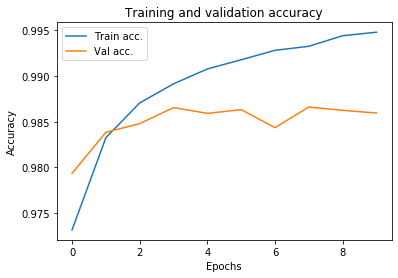

In [28]:
training_accuracy=[]
training_accuracy.append(history.history['acc'])
validation_accuracy=[]
validation_accuracy.append(history.history['val_acc'])
plt.figure()
plt.plot(training_accuracy[0])
plt.plot(validation_accuracy[0]) 
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train acc.','Val acc.'])
plt.show()

Confusion matrix

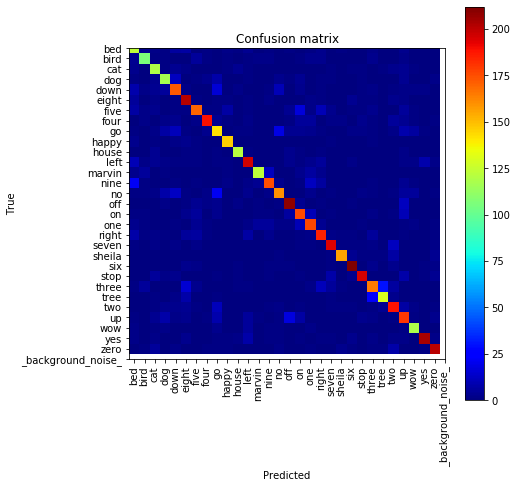

In [26]:
test_set = test_set.reshape(-1,40,98,1)
predictions = classifier.predict(test_set)
new_test_labels = np.zeros(test_labels.shape[0])

for i in range(test_labels.shape[0]):
    new_test_labels[i]=np.argmax(test_labels[i])
y_pred = np.zeros(test_labels.shape[0])

for i in range(test_labels.shape[0]):
    y_pred[i]=np.argmax(predictions[i])

cm = confusion_matrix(y_true=new_test_labels,y_pred=y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm,interpolation='nearest',cmap=plt.cm.jet)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(31)
plt.xticks(tick_marks,words_name,rotation=90)
plt.yticks(tick_marks,words_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

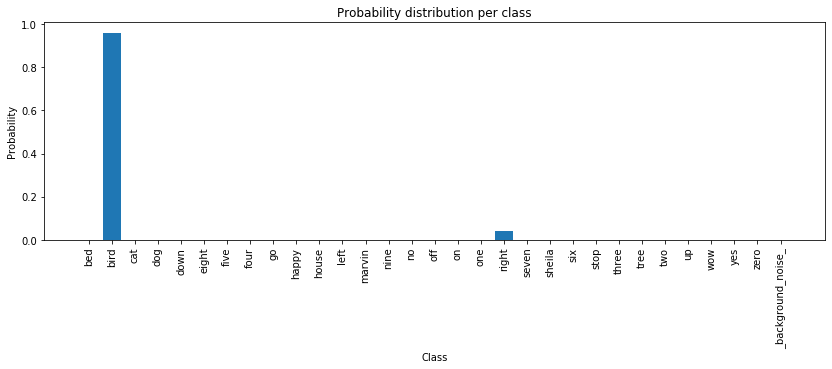

In [31]:
fs, signal = wavfile.read('./audio_files/bird/00b01445_nohash_0.wav')
winsound.PlaySound('./audio_files/bird/00b01445_nohash_0', winsound.SND_FILENAME)
filter_bank,length=creation_filterbank(fs,signal)
audio_signal=np.zeros((1,40,98,1))
audio_signal[0,:,:,0]=filter_bank.T

plt.figure(figsize=(14,4))
plt.bar(words_name,classifier.predict(audio_signal)[0])
plt.title('Probability distribution per class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=90)
plt.show()